In [379]:
import cv2
import torch
import random
import copy
import time

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from math import cos,sin,pi
from PIL import Image
from PIL import ImageChops
from collections import defaultdict

## Data Preprocessing

1. 数据处理新增标签
2. 创建非脸部样本：根据脸部方框大小，随机剪裁相同大小图块，并且保证图块内不含标记的关键点

In [155]:
floder_path = ['./项目二/data/I/', './项目二/data/II/']

def creat_data(floder_path):
    """
    return data_dict 一张图上的所有脸
    """
    data_dict = defaultdict(list)
    data = defaultdict(list)
    for url in floder_path:
        with open((url + 'label.txt')) as f:
            lines = f.readlines()

            for line in lines:
                line = line.split()

                line[0] = url + line[0]
                line[1: 5] = expand_roi(line[1: 5], 0.25, line[0])
                line[5:] = np.array([float(i) for i in line[5:]]).reshape(-1, 2)
                line.append(1)
                
                # 扩大后点边界范围
                x_limit1, y_limit1, x_limit2, y_limit2 = line[1: 5]
                x1, y1, x2, y2 = line[1: 5]
                for i, j in line[5: -1]:
                    if i > x_limit2 or i < x_limit1 or j < y_limit1 or j > y_limit2:
                        break
                else:
                    data_dict[line[0]].append(line)
                    
                    p = random.uniform(0, 1)
                    if p > 0.3:
                        data['train'].append(line)

                    elif 0.1 < p < 0.3:
                        data['valid'].append(line)

                    else:
                        data['test'].append(line)

                    
    return data_dict, data

# 脸部范围扩大

def expand_roi(face_list, ratio, img_url):
    img = cv2.imread(img_url)
    img_height, img_width, _ = img.shape
    x1, y1, x2, y2 = [int(float(i)) for i in face_list]
    
    width = x2 - x1 + 1
    height = y2 - y1 + 1
    padding_width = int(width * ratio)
    padding_height = int(height * ratio)
    
    roi_x1 = x1 - padding_width
    roi_y1 = y1 - padding_height
    roi_x2 = x2 + padding_width
    roi_y2 = y2 + padding_height
    roi_x1 = 0 if roi_x1 < 0 else roi_x1
    roi_y1 = 0 if roi_y1 < 0 else roi_y1
    roi_x2 = img_width - 1 if roi_x2 >= img_width else roi_x2
    roi_y2 = img_height - 1 if roi_y2 >= img_height else roi_y2
    
    return [roi_x1, roi_y1, roi_x2, roi_y2]

data_dict, data = creat_data(floder_path)

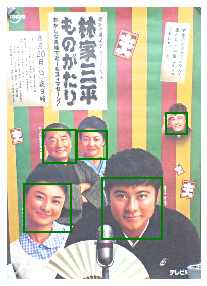

In [200]:
sample = data_dict['./项目二/data/I/001658.jpg']
img = np.array(Image.open(sample[0][0]))
fig, ax = plt.subplots(figsize=(10,5))
for line in sample:
    x1, y1, x2, y2 = line[1: 5]
    rect = plt.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    

ax.axis('off')
ax.imshow(img)
plt.show()

#### 创建负样本

In [164]:
def get_negative_samples(data, data_dict, nums):
    negative_samples = []
    for sample in data:
        # 拿到所有脸的标记
        landmarks = []
        face_list = data_dict[sample[0]]
        for face in face_list:
            for landmark in face[5:-1]:
                landmarks.append(landmark)
                
        img = Image.open(sample[0])
        w, h = img.size
        x1, y1, x2, y2 = sample[1:5]
        w_rect = x2 - x1
        h_rect = y2 - y1

        n = 0
        limit = 0
        while n < nums and limit < 5:
            x_random = random.randint(0, w - w_rect)
            y_random = random.randint(0, h - h_rect)

            for j in landmarks:
                if not(j[0] < x_random or j[0] > x_random + w_rect or j[1] < y_random or j[1] > y_random + h_rect):
                    limit += 1
                    break
            else:
                tmp = [sample[0]] + [x_random, y_random, x_random + w_rect, y_random + h_rect] + [x_random, y_random] * 21 + [0]
                negative_samples.append(tmp)
                n += 1
                
    return negative_samples
                
negative_samples = get_negative_samples(data['test'], data_dict, 2)

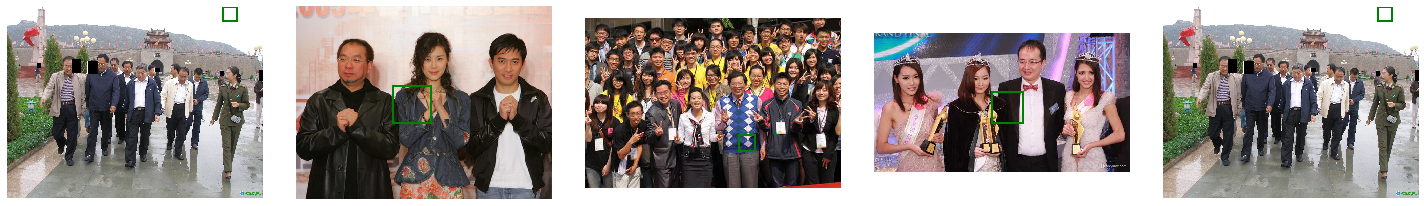

In [363]:
def my_show(data, nums, figsize=(20, 10)):
    
    fig = plt.figure(figsize=figsize)
    
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        n = random.randint(1, 200)
        img_data = data[n]
        ax.axis('off')
    
        # 图片展示
        img_url = img_data[0]
        
        img = cv2.imread(img_url)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)

        # 人脸矩形展示
        x1, y1, x2, y2 = img_data[1: 5]
        rect = plt.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

        # 特征点展示
#         landmarks_X = img_data[5::2]
#         landmarks_Y = img_data[6::2]
#         ax.scatter(landmarks_X, landmarks_Y, s=10, marker='.', c='r')


my_show(negative_samples, nums=5)

In [173]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, data, transform=None):
        self.negative_samples = get_negative_samples(data, data_dict, 2)
        self.positive_samples = data
        
        self.data = self.negative_samples + self.positive_samples
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        line = self.data[idx]
        img_name, rect, landmarks, label = line[0], line[1: 5], line[5: -1], line[-1]
        
        # 人脸范围剪裁
        img = Image.open(img_name).convert('RGB')
        image = img.crop(rect)

        # 标准化标记点
        landmarks = np.asarray(landmarks, dtype=np.float32).reshape(-1, 2)
        landmarks -= rect[:2]
        
        sample = {'image': image, 'landmarks': landmarks, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    


In [174]:
class Random_Rotate:
    
    def __init__(self, angle_limit):
        self.angle = angle_limit
    
    def rotate(self, pst, angle, cx, cy):
        """
        点(x,y) 绕(cx,cy)点旋转
        """
        x, y = pst
        angle = -(angle*pi/180)
        x_new = (x-cx)*cos(angle) - (y-cy)*sin(angle) + cx
        y_new = (x-cx)*sin(angle) + (y-cy)*cos(angle) + cy
        return x_new,y_new
    
    
    def __call__(self, sample):
        """
        注意：
        1, 如果以下形式调用，angle会传入两次不一样的random值
        input_img = batch['image']
        target_pts = batch['landmarks']
        """
        image, landmarks, label = sample.values()
        # 随机角度
        if label == 0:
            return {'image': image, 'landmarks': landmarks, 'label': label}
        
        while True:
            n = random.uniform(0, 1)
            if n < 0.5:
                return {'image': image, 'landmarks': landmarks, 'label': label}
            
            angle = random.randint(-self.angle, self.angle)
            h, w = np.array(image).shape[:2]

            img = image.rotate(angle, Image.BILINEAR)
            
#             Image.BICUBIC
            lan = np.array([self.rotate(point, angle, w/2, h/2) for point in landmarks])
            
            for i, j in lan:
                if i > w or i < 0 or j < 0 or j > h:
                    break
            else:
                return {'image': img, 'landmarks': lan, 'label': label}

class Random_HorizontalFlip:
    def __call__(self, sample):
        image, landmarks, label = sample.values()
        pred = random.uniform(0, 1)
        if pred < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            h, w = np.array(image).shape[:2]
            landmarks[:, 0] = w - landmarks[:, 0]
        
        return {'image': image, 'landmarks': landmarks, 'label': label}
    
class Random_Move:
    
    def __init__(self, dis):
        self.dis = dis
    
    def __call__(self, sample):
        image, landmarks, label = sample.values()
        if label == 0:
            return {'image': image, 'landmarks': landmarks, 'label': label}
        while True:
            n = random.uniform(0, 1)
            if n < 0.5:
                return {'image': image , 'landmarks': landmarks, 'label': label}

            h, w = np.array(image).shape[:2]
            x = random.randint(-self.dis, self.dis)
            y = random.randint(-self.dis, self.dis)
            img = ImageChops.offset(image, x, y)
            lan = landmarks + [x, y]

            for i, j in lan:
                if i > w or i < 0 or j < 0 or j > h:
                    break
            else:
                return {'image': img, 'landmarks': lan, 'label': label}
        
        


In [175]:
class Crop_Risize:
    def __call__(self, sample, train_boarder=112):
        image, landmarks, label = sample.values()

        image_width, image_height = image.size
        image = image.resize((train_boarder, train_boarder),Image.BILINEAR)  # Image.ANTIALIAS
        image = np.asarray(image, dtype=np.float32)
        # 标准化landmarks
        landmarks[:, 0] = landmarks[:, 0] * train_boarder / image_width
        landmarks[:, 1] = landmarks[:, 1] * train_boarder / image_height
        
        return {'image': image, 'landmarks': landmarks, 'label': label}

class Normalize:
    def __call__(self, sample):
        image, landmarks, label = sample.values()
        
#         image = (image - np.mean(image)) / (np.std(image) + 1e-7)
        image /= 255.0
        landmarks /= 112
        
        return {'image': image, 'landmarks': landmarks, 'label': label}

class ToTensor:
    def __call__(self, sample):
        image, landmarks, label = sample.values()
            
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        landmarks = landmarks.ravel()
        landmarks = torch.from_numpy(landmarks).float()

        return {'image': image, 'landmarks': landmarks, 'label': label}

[3507, 4211, 3732, 35, 715]
[1, 1, 1, 0, 0]


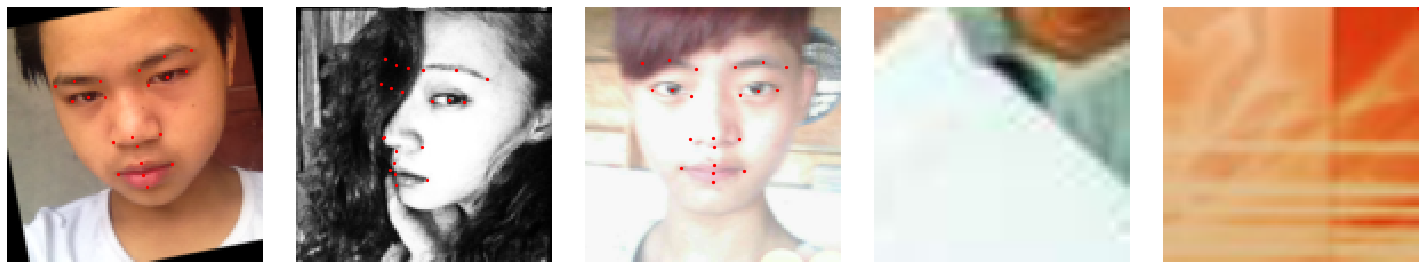

In [203]:
# 数据可视化展示

def my_show(data, nums):
    fig = plt.figure(figsize=(20, 5))
    lst = []
    labels = []
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(0, len(data))
        lst.append(n)
        img, landmarks,label = data[n].values()
        img = img.numpy() * 255
        img = img.astype('uint8')
        img = img.transpose((1,2,0))
        landmarks = landmarks.numpy() * 112
        
        X = landmarks[0::2]
        Y = landmarks[1::2]
        ax.scatter(X, Y, s=20, marker='.', c='r')
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        labels.append(label)
    print(lst)
    print(labels)
        
        
trfm = transforms.Compose([Random_HorizontalFlip(),
                           Random_Rotate(20), 
                           Random_Move(10), 
                           Crop_Risize(), Normalize(), ToTensor()])

img_show = FaceLandmarksDataset(data['train'], transform=trfm)
my_show(img_show, 5)

## Net

1. 网络结构新增一个判断label的分支

In [392]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # in_channel, out_channel, kernel_size, stride, padding
        self.conv1_1 = nn.Conv2d(3, 8, 5, 2, 0)
        self.conv2_1 = nn.Conv2d(8, 16, 3, 1, 0)
        self.conv2_2 = nn.Conv2d(16, 16, 3, 1, 0)
        self.conv3_1 = nn.Conv2d(16, 24, 3, 1, 0)
        self.conv3_2 = nn.Conv2d(24, 24, 3, 1, 0)
        self.conv4_1 = nn.Conv2d(24, 40, 3, 1, 1)
        self.conv4_2 = nn.Conv2d(40, 80, 3, 1, 1)
        
        self.ip1 = nn.Linear(4 * 4 * 80, 128)
        self.ip2 = nn.Linear(128, 128)
        self.ip3 = nn.Linear(128, 42)
        self.ip4 = nn.Linear(42, 2)
        
        self.prelu = nn.PReLU()
        
        self.ave_pool = nn.AvgPool2d(2, 2, ceil_mode=True)
        
    def forward(self, x):
        x = self.ave_pool(self.prelu(self.conv1_1(x)))
                                    # in：32*3*112*112  out：32*8*27*27
                                    # conv: (112 - 5) // 2 + 1 = 54  pooling: 52 / 2 = 27
        x = self.prelu(self.conv2_1(x))
                                    # out: 32*16*25*25
        x = self.prelu(self.conv2_2(x))
                                    # out: 32*16*23*23
        x = self.ave_pool(x)
                                    # out: 32*16*12*12
        x = self.prelu(self.conv3_1(x))
                                    # out: 32*24*10*10
        x = self.prelu(self.conv3_2(x))
                                    # out: 32*24*8*8
        x = self.ave_pool(x)
                                    # out: 32*24*4*4
        x = self.prelu(self.conv4_1(x))
                                    # out: 32*40*4*4
        # stage 3 branch
        
        y = self.prelu(self.conv4_2(x))
        x = self.prelu(self.conv4_2(x))
                                    # out: 32*80*4*4
        # FC
        y = y.view(-1, 4 * 4 * 80)
        x = x.view(-1, 4 * 4 * 80)
                                    # out: 32*1280
        y = self.prelu(self.ip1(y))
        x = self.prelu(self.ip1(x))
                                    # out: 32*128
        y = self.prelu(self.ip2(y))
        x = self.prelu(self.ip2(x))
                                    # out: 32*128
        y = self.prelu(self.ip3(y))
        landmarks = self.prelu(self.ip3(x))
                                    # out: 32*42   (21组坐标点)
        label = self.ip4(y)
                                    # out: 32*2   (二分类)
        return label, landmarks
    

## Train

1. label和landmarks loss增加了权重平衡尺度
2. landmarks loss 计算增加蒙板，只计算label为1的loss（所以之后训练的时候，一开始landmarks会比较低）
3. 增加label正确率计算

In [393]:
# 训练模型

def train(train_loader, valid_loader, model, criterion_MSE, criterion_CE, optimizer, epoch, scheduler=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_valid_loss = float('inf')
    
    for epoch_idx in range(epoch):
        # Training the model
        model.train()
        loss_ave = 0.0
        face_ave = 0.0
        lan_ave = 0.0
        for batch_idx, batch in enumerate(train_loader):
            image, landmarks, label = batch.values()
            image = image.to(device)
            landmarks = landmarks.to(device)
            label = label.to(device)
            
            face, point = model(image)

            loss_face = criterion_CE(face, label) * 400
            loss_landmarks = criterion_MSE(point[label == 1], landmarks[label == 1])

            loss = loss_face + loss_landmarks

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_ave += loss.item()
            face_ave += loss_face.item()
            lan_ave += loss_landmarks.item()
            
    
        loss_ave /= len(iter(train_loader))
        face_ave /= len(iter(train_loader))
        lan_ave /= len(iter(train_loader))
        
            
          
            
#           打印结果
        if epoch_idx % 50 == 0:
            print(f'Train Epoch: {epoch_idx}')
            print('Train: loss_totle: {:.4f} loss_face: {:.4f} loss_landmarks: {:.4f}'.format(
                     loss.item(), loss_face.item(), loss_landmarks.item()))
        
#       Validate the model
        model.eval()
        with torch.no_grad():

            loss_face_totle = 0.0
            loss_lan_totle = 0.0
            acc_positive = 0.0
            acc_negative = 0.0
            times = 0
            for valid_batch_idx, batch in enumerate(valid_loader):
                image, landmarks, label = batch.values()
                image = image.to(device)
                landmarks = landmarks.to(device)
                label = label.to(device)
    
                face, point = model(image)
        
                loss_face = criterion_CE(face, label)
                loss_landmarks = criterion_MSE(point[label == 1], landmarks[label == 1])
                _, pred = torch.max(face, 1)
                
                acc_positive += (label[label == 1] == pred[label == 1]).sum().item() / (label[label == 0].size(0))
                acc_negative += (label[label == 0] == pred[label == 0]).sum().item() / (label[label == 0].size(0))
                
                loss_face_totle += (400 * loss_face).item()
                loss_lan_totle += loss_landmarks.item()
                
                times += 1
                
            
            loss_face_totle /= times
            loss_lan_totle /= times
            loss_totle = loss_face_totle + loss_lan_totle
            acc_positive /= times
            acc_negative /= times
            
            if loss_totle < best_valid_loss:
                best_valid_loss = loss_totle
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if epoch_idx % 50 == 0:
                print('Valid: loss_totle: {:.4f} loss_face: {:.4f} loss_landmarks: {:.4f}'.format(loss_totle, loss_face_totle, loss_lan_totle))
                print('Face: acc_positive: {:.4f}, acc_negative: {:.4f}'.format(acc_positive, acc_negative))
                print('-' * 50)
#         更新lr
        if scheduler:
            scheduler.step()
        
#     保存模型
    model.load_state_dict(best_model_wts)
    time_elapesd = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapesd // 60, time_elapesd % 60))
    print('Best val loss: {:4f}'.format(best_valid_loss))
    return model




In [394]:
# 超参数调整
lr = 0.001
batch_size = 64
momentum = 0.9
epoch = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Transform
trfm = transforms.Compose([
    Random_HorizontalFlip() ,
    Random_Rotate(20), 
    Random_Move(10), 
    Crop_Risize(), Normalize(), ToTensor()])
trfm_test = transforms.Compose([Crop_Risize(), Normalize(), ToTensor()])

# Dataset
train_set = FaceLandmarksDataset(data['train'], transform=trfm)
valid_set = FaceLandmarksDataset(data['valid'], transform=trfm_test)
test_set = FaceLandmarksDataset(data['test'], transform=trfm_test)

# DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)


In [395]:
model = Net().to(device)

criterion_MSE = nn.MSELoss(reduction='sum')

# 增加分类权重，因为是样本比例是 2: 1
weight = torch.FloatTensor([1, 2])
criterion_CE = nn.CrossEntropyLoss(weight=weight)

optimizer = optim.Adam(model.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_stage3 = train(train_loader, valid_loader, model, criterion_MSE, criterion_CE, optimizer, epoch)
torch.save(model_stage3, './model_stage3.pth')


Train Epoch: 0
Train: loss_totle: 282.1231 loss_face: 271.1581 loss_landmarks: 10.9650
Valid: loss_totle: 282.9398 loss_face: 269.8646 loss_landmarks: 13.0751
Face: acc_positive: 0.7408, acc_negative: 0.0000
--------------------------------------------------
Train Epoch: 50
Train: loss_totle: 31.8841 loss_face: 23.2593 loss_landmarks: 8.6249
Valid: loss_totle: 55.7392 loss_face: 40.7471 loss_landmarks: 14.9921
Face: acc_positive: 0.7093, acc_negative: 0.9684
--------------------------------------------------
Train Epoch: 100
Train: loss_totle: 21.0221 loss_face: 13.5270 loss_landmarks: 7.4951
Valid: loss_totle: 49.6511 loss_face: 34.9193 loss_landmarks: 14.7318
Face: acc_positive: 0.7141, acc_negative: 0.9846
--------------------------------------------------
Train Epoch: 150
Train: loss_totle: 11.4429 loss_face: 0.5737 loss_landmarks: 10.8692
Valid: loss_totle: 53.5598 loss_face: 37.8491 loss_landmarks: 15.7108
Face: acc_positive: 0.7303, acc_negative: 0.9606
-------------------------

In [396]:
torch.save(model_stage3, './model_stage3.pth')

## Visualize

In [417]:
def Visualize(model_url):
    test_model = torch.load(model_url)
    test_model.eval()

    with torch.no_grad():
        test = next(iter(test_loader))

        
        image, landmarks, label = test.values()

        face, point = model(image)

        loss_face = criterion_CE(face, label) * 400
        loss_landmarks = criterion_MSE(point[label == 1], landmarks[label == 1])
        loss = loss_face + loss_landmarks
        
        _, pred = torch.max(face, 1)

        acc_positive = (label[label == 1] == pred[label == 1]).sum().item() / (label[label == 1].size(0))
        acc_negative = (label[label == 0] == pred[label == 0]).sum().item() / (label[label == 0].size(0))
        
        print('Test: loss_totle: {:.4f} loss_face: {:.4f} loss_landmarks: {:.4f}'.format(loss, loss_face, loss_landmarks))
        print('Face: acc_positive: {:.4f}, acc_negative: {:.4f}'.format(acc_positive, acc_negative))
            
    
    fig = plt.figure(figsize=(20, 5))
    label = []
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.tight_layout()

        n = random.randint(0, batch_size)

        img = image[n].numpy() * 255
        img = img.astype('uint8')
        img = img.transpose((1, 2, 0))
        lan = point[n].numpy() * 112
        lan = lan.reshape(-1, 2)
        label.append(pred[n].item())
        
        if pred[n] == 1:
            ax.scatter(lan[:, 0], lan[:, 1], s=20, marker='.', c='r')
            
        ax.imshow(img)
        ax.axis('off')
    print(label)

Test: loss_totle: 92.8655 loss_face: 78.9594 loss_landmarks: 13.9060
Face: acc_positive: 0.9500, acc_negative: 0.9773
[1, 0, 1, 1, 0]


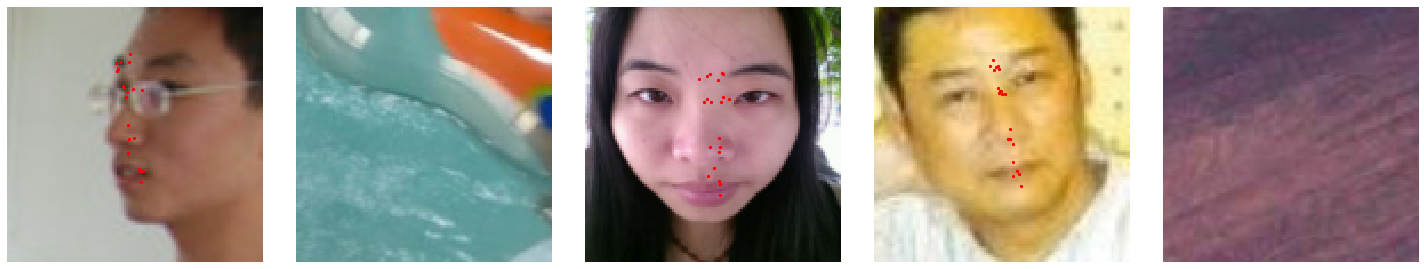

In [418]:
Visualize('./model_stage3.pth')